In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

plt.style.use("~/evanstyle.mplstyle")

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [22]:
#toproot = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
toproot = "../../data/"
topdirs = {7:toproot+"Run7/", 8:toproot+"Run8/", 9:toproot+"Run9/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



/Users/linsi/Documents/stanford/HV/analysis/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:137: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [23]:
#load data into mem if you want
df7 = pickle.load(open("../../data/Run7/cosmics-endofrun/reduced.p", "rb"))[0]

In [24]:
from scipy.stats import poisson

# Calculate the minimum time (in seconds) for normalization
min_t_sec = np.min(df7["ch0 seconds"])
df7.loc[:, "ch0 tzerod"] = (df7["ch0 seconds"] - min_t_sec) + df7["ch0 nanoseconds"] / 1e9

df7 = df7.sort_values(by="ch0 tzerod")

# Calculate the absolute time
df7.loc[:, "abs_time"] = df7["ch0 seconds"] + df7["ch0 nanoseconds"] / 1e9


# Calculate the number of events in each 10-second interval
dur = 10 # seconds
start_time = df7["abs_time"].min()
end_time = df7["abs_time"].max()
bins = np.arange(start_time, end_time + dur, dur)

# Calculate the 99.9% confidence interval using Poisson distribution
lambda_value = 8.8
confidence_level = 0.999
interval = poisson.interval(confidence_level, lambda_value)
upper_limit = interval[1]
down_limit = interval[0]

df7['interval'] = pd.cut(df7["abs_time"], bins, right=False)

# Calculate the number of events in each interval
event_counts = df7.groupby('interval', observed=False).size()

# Find the start times of intervals where event count exceeds the upper limit
exceed_intervals = event_counts[event_counts > upper_limit].index

# Extract the left edge (start times) of these intervals
exceed_times = [(interval.left, event_counts[interval])for interval in exceed_intervals]

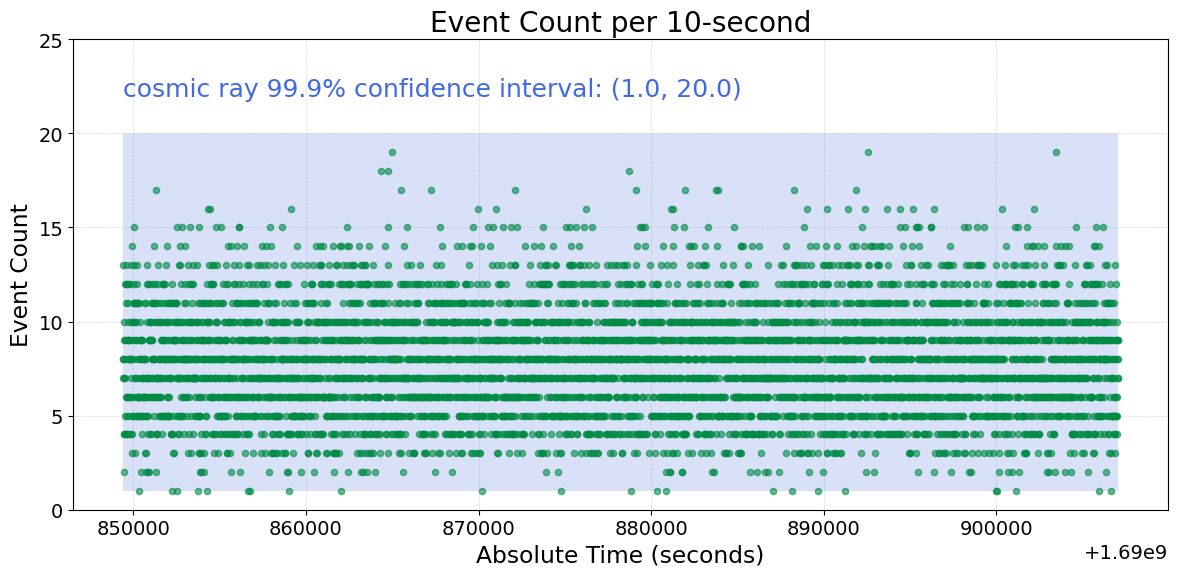

Times with event count exceeding upper limit: []


In [25]:
# Remove intervals with zero events
filtered_intervals = event_counts[event_counts != 0].index.categories.left.values[event_counts[event_counts != 0].index.codes]
filtered_nev = event_counts[event_counts != 0].values

# Plot the event count over time
plt.figure(figsize=(12, 6))

# Fill the area between the confidence interval limits
plt.fill_between(filtered_intervals, down_limit, upper_limit, color='#4169E1', alpha=0.2, edgecolor='none')

# Plot the event counts
plt.scatter(filtered_intervals, filtered_nev, marker='o', s=20, c='#008B45', alpha=0.6)

# Add annotation with confidence interval information
plt.text(start_time, 22, f'cosmic ray {confidence_level * 100}% confidence interval: {interval}', fontsize=18, color='#4169E1')
plt.ylim([0, 25])
# Set labels and title
plt.xlabel('Absolute Time (seconds)')
plt.ylabel('Event Count')
plt.title('Event Count per 10-second')
plt.grid(True, linestyle= '--', alpha=0.7)
plt.tight_layout()
#plt.ylim([0, 40])
plt.show()

# Print the times with event count exceeding the upper limit
print("Times with event count exceeding upper limit:", exceed_times)

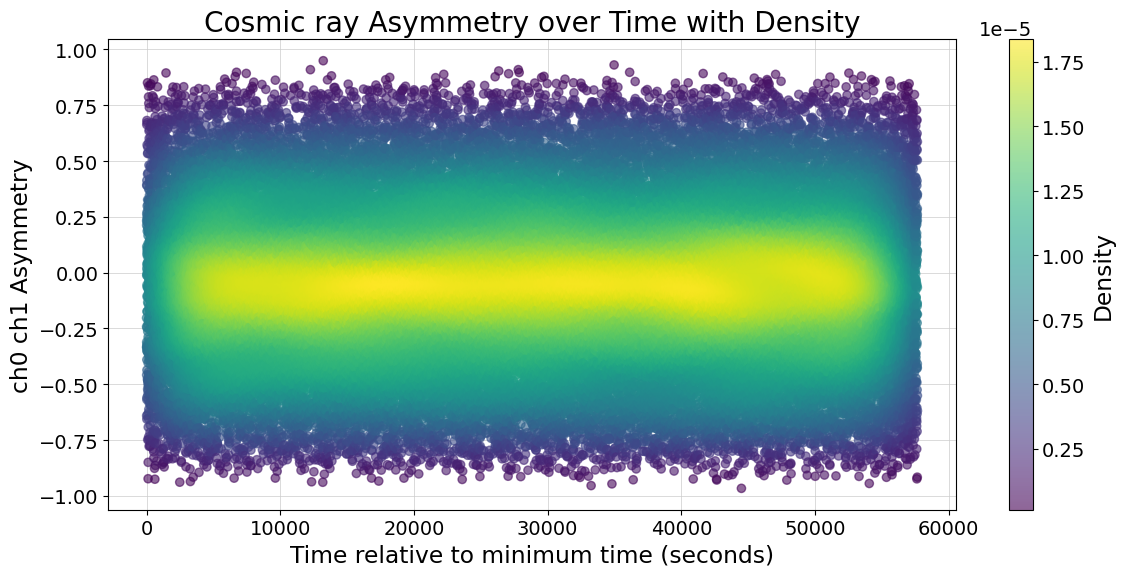

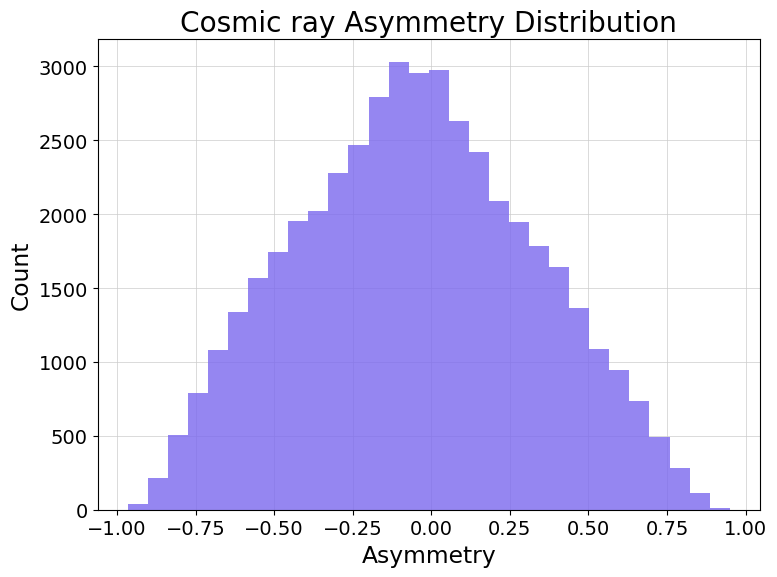

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import gaussian_kde

# Load data into memory
df7 = pickle.load(open("../../data/Run7/cosmics-endofrun/reduced.p", "rb"))[0]

# Calculate the minimum time (in seconds) for normalization
min_t_sec = np.min(df7["ch0 seconds"])
df7.loc[:, "ch0 tzerod"] = (df7["ch0 seconds"] - min_t_sec) + df7["ch0 nanoseconds"] / 1e9

df7 = df7.sort_values(by="ch0 tzerod")

# Calculate the absolute time
df7.loc[:, "abs_time"] = df7["ch0 seconds"] + df7["ch0 nanoseconds"] / 1e9

# Ensure abs_time is of numeric type
df7["abs_time"] = df7["abs_time"].astype(float)

# Filter data for light channel events
df7_ch0_events = df7.dropna(subset=["ch0 amp", "ch0 baseline"])
df7_ch1_events = df7.dropna(subset=["ch1 amp", "ch1 baseline"])

# Compute signal for ch0 and ch1
df7_ch0_events["ch0 signal"] = df7_ch0_events["ch0 amp"] - df7_ch0_events["ch0 baseline"]
df7_ch1_events["ch1 signal"] = df7_ch1_events["ch1 amp"] - df7_ch1_events["ch1 baseline"]

# Merge ch0 and ch1 events based on the closest absolute time
merged_df = pd.merge_asof(df7_ch0_events.sort_values('abs_time'), df7_ch1_events.sort_values('abs_time'), on='abs_time', suffixes=('_ch0', '_ch1'))

# Ensure the merged columns are numeric types
merged_df["abs_time"] = merged_df["abs_time"].astype(float)
merged_df["ch0 signal"] = merged_df["ch0 signal"].astype(float)
merged_df["ch1 signal"] = merged_df["ch1 signal"].astype(float)

# Compute asymmetry
merged_df["asymmetry"] = (merged_df["ch0 signal"] - merged_df["ch1 signal"]) / (merged_df["ch0 signal"] + merged_df["ch1 signal"])

# Compute density
xy = np.vstack([merged_df["abs_time"] - min_t_sec, merged_df["asymmetry"]])
z = gaussian_kde(xy)(xy)

# Plot asymmetry over time with density
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(merged_df["abs_time"] - min_t_sec, merged_df["asymmetry"], c=z, cmap='viridis', alpha=0.6)
cbar = plt.colorbar(sc)
cbar.set_label('Density')
ax.set_xlabel("Time relative to minimum time (seconds)")
ax.set_ylabel("ch0 ch1 Asymmetry")
ax.set_title("Cosmic ray Asymmetry over Time with Density")
ax.grid(True)
plt.tight_layout()
plt.show()

# Plot asymmetry distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(merged_df["asymmetry"], bins=30, color='#7B68EE', alpha=0.8)
ax.set_xlabel("Asymmetry")
ax.set_ylabel("Count")
ax.set_title("Cosmic ray Asymmetry Distribution")
ax.grid(True)
plt.tight_layout()
plt.show()